# ANOVA

This notebook shows several examples of one-way and two-way ANOVAs using Pingouin.

***


## One-way ANOVA

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. In Pingouin, the one-way ANOVA is implemented in the [anova](https://pingouin-stats.org/generated/pingouin.anova.html#pingouin.anova) function. The ANOVA test has three main assumptions that must be satisfied to provide accurate results:

1. The samples must be independent (i.e. by opposition with repeated measurements in a single group, in which case one should use repeated measures ANOVA [(rm_anova)](https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova).
2. Each sample should be normally distributed.
3. The variance of the samples are all equal (= homoscedasticity).

*Note that assumptions #2 and #3 can be checked using the [normality](https://pingouin-stats.org/generated/pingouin.normality.html#pingouin.normality) and [homoscedasticity](https://pingouin-stats.org/generated/pingouin.homoscedasticity.html#pingouin.homoscedasticity) functions.*

### Load data

For this first example, we are going to load the McClave (1991) dataset which compares the pain threshold of subjects as a function of their hair color.

In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

df = pg.read_dataset('anova')

df.groupby('Hair color')['Pain threshold'].agg(['mean', 'std', 'count']).round(2)

,mean,std,count
Hair color,,,
Dark Blond,51.2,9.28,5
Dark Brunette,37.4,8.32,5
Light Blond,59.2,8.53,5
Light Brunette,42.5,5.45,4


### Run the ANOVA


To run a one-way ANOVA in pingouin, the following arguments MUST be specified:

* data : the pandas DataFrame (in long-format)
* dv : the dependant variable
* between : the between-subject factor

In [2]:
from pingouin import anova

aov = pg.anova(data=df, dv='Pain threshold', between='Hair color', detailed=True)
# Similar to df.anova(dv='Pain threshold', between='Hair color', detailed=True)

aov

,Source,SS,DF,MS,F,p-unc,np2
0,Hair color,1360.726316,3,453.575439,6.791407,0.004114,0.575962
1,Within,1001.800000,15,66.786667,NaN,NaN,NaN


The detailed ANOVA summary table includes the following columns:

- SS : sums of squares
- DF : degrees of freedom
- MS : mean squares (= SS / DF)
- F : F-value (test statistic)
- p-unc : uncorrected p-values
- np2 : partial eta-square effect size \*

\* *In one-way ANOVA, partial eta-square is the same as eta-square and generalized eta-square.*

In the example above, there is a main effect of group (F(3, 15) = 6.79, p = .004)), so we can reject the null hypothesis that the groups have equal means.

### Tukey post-hocs

Often, you will want to compute post-hoc tests to look at the pairwise differences between the groups. For one-way ANOVA with equal variances between groups, the optimal test is the [pairwise_tukey](https://pingouin-stats.org/generated/pingouin.pairwise_tukey.html#pingouin.pairwise_tukey) post-hoc test.

As one can see from the post-hoc summary table below, the light blond group has a significantly higher pain threshold than the dark brunette (p=.0037) and light brunette (p=.0367) groups.

In [3]:
pg.pairwise_tukey(data=df, dv='Pain threshold', between='Hair color')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,Dark Blond,Dark Brunette,51.2,37.4,13.8,5.168623,two-sided,2.669957,0.047668,1.525213
1,Dark Blond,Light Blond,51.2,59.2,-8.0,5.168623,two-sided,-1.547801,0.413344,-0.884182
2,Dark Blond,Light Brunette,51.2,42.5,8.7,5.482153,two-sided,1.586968,0.391353,0.946285
3,Dark Brunette,Light Blond,37.4,59.2,-21.8,5.168623,two-sided,-4.217758,0.001000,-2.409395
4,Dark Brunette,Light Brunette,37.4,42.5,-5.1,5.482153,two-sided,-0.930291,0.759120,-0.554719
5,Light Blond,Light Brunette,59.2,42.5,16.7,5.482153,two-sided,3.046249,0.017775,1.816432


### Power of the ANOVA
In some cases, it might be useful to compute the power of the test, i.e. the probability that we correctly reject the null hypothesis when it is indeed false (with higher power indicating higher reliability). This can be calculated easily from the ANOVA summary using the [power_anova](https://pingouin-stats.org/generated/pingouin.power_anova.html#pingouin.power_anova) function.

In [4]:
k = df['Hair color'].nunique()  # Number of groups
n = df.shape[0] / k  # Number of observations per group
achieved_power = pg.power_anova(eta=aov.loc[0, 'np2'], k=k, n=n, alpha=0.05)
print('Achieved power: %.4f' % achieved_power)

Achieved power: 0.9729


### Assumptions check

Finally, to check that (1) each sample is normally distributed and (2) the variance of the samples are all equal, we can use the [normality](https://pingouin-stats.org/generated/pingouin.normality.html#pingouin.normality) and [homoscedasticity](https://pingouin-stats.org/generated/pingouin.homoscedasticity.html#pingouin.homoscedasticity) functions, respectively. The first output value of these two functions is a boolean that indicates whether the assumption is met (True) or not (False). The second value is the corresponding p-value of the test.

In [5]:
pg.normality(df, group='Hair color', dv='Pain threshold')

,W,pval,normal
Light Blond,0.991032,0.983182,True
Dark Blond,0.939790,0.664456,True
Light Brunette,0.930607,0.597973,True
Dark Brunette,0.883214,0.324129,True


In [6]:
pg.homoscedasticity(df, group='Hair color', dv='Pain threshold')

,W,pval,equal_var
levene,0.392743,0.760016,True


### What if my groups have unequal variances?

Traditional ANOVA can be quite unstable when the groups have unequal variances (see [Liu 2015](https://scholarscompass.vcu.edu/cgi/viewcontent.cgi?article=5026&context=etd)). Therefore, it is recommanded to use a Welch ANOVA instead, followed by Games-Howell post-hoc tests, which do not require the groups to have equal variances.

In [7]:
pg.welch_anova(data=df, dv='Pain threshold', between='Hair color')

,Source,ddof1,ddof2,F,p-unc,np2
0,Hair color,3,8.329841,5.890115,0.018813,0.575962


In [8]:
pg.pairwise_gameshowell(data=df, dv='Pain threshold', between='Hair color')

,A,B,mean(A),mean(B),diff,se,tail,T,df,pval,hedges
0,Dark Blond,Dark Brunette,51.2,37.4,13.8,3.943349,two-sided,2.474565,7.906609,0.085833,1.413596
1,Dark Blond,Light Blond,51.2,59.2,-8.0,3.986226,two-sided,-1.419100,7.942669,0.486931,-0.810661
2,Dark Blond,Light Brunette,51.2,42.5,8.7,3.511173,two-sided,1.752072,6.562510,0.314347,1.044734
3,Dark Brunette,Light Blond,37.4,59.2,-21.8,3.768289,two-sided,-4.090697,7.995416,0.001186,-2.336811
4,Dark Brunette,Light Brunette,37.4,42.5,-5.1,3.261646,two-sided,-1.105652,6.821772,0.656084,-0.659283
5,Light Blond,Light Brunette,59.2,42.5,16.7,3.313357,two-sided,3.563964,6.772089,0.006721,2.125137


***

## One-way repeated measures ANOVA

The one-way repeated measures ANOVA is the equivalent of the one-way ANOVA, but for related, not independent groups. It is sometimes called within-subjects ANOVA. 

In Pingouin, the one-way repeated measures ANOVA is implemented in the [rm_anova](https://pingouin-stats.org/generated/pingouin.rm_anova.html#pingouin.rm_anova) function. The repeated measures ANOVA test has several assumptions that must be satisfied to provide accurate results:

- Normality: for each level of the within-subjects factor, the dependent variable must have a normal distribution.
- Sphericity: difference scores computed between two levels of a within-subjects factor must have the same variance for the comparison of any two levels. (This assumption only applies if there are more than 2 levels of the independent variable.)
- Randomness: cases should be derived from a random sample, and scores from different participants should be independent of each other.

### Load data

For this first example, we are going to create a fake dataset comprising the memory scores (on a 1-to-5 scale) of 20 older adults acquired with a four-year interval. The objective of the study is to see how memory deteriorates with aging.

In [9]:
# Ensure reproducibility of the results
np.random.seed(123)

# Create three normally-distributed vectors.
n = 20
perf2010 = np.random.normal(loc=5, scale=0.8, size=n)     # Mean = 5, standard deviation = 0.8, size = 20
perf2014 = np.random.normal(loc=4.8, scale=0.8, size=n)   # Mean = 4.8, ...
perf2018 = np.random.normal(loc=3, scale=0.8, size=n)     # Mean = 3, ...

# Concatenate in a long-format pandas DataFrame
df = pd.DataFrame({'Memory': np.r_[perf2010, perf2014, perf2018],
                   'Year': np.repeat(['2010', '2014', '2018'], n),
                   'Subject': np.tile(np.arange(n), 3)})
df.head()

,Memory,Year,Subject
0,4.131496,2010,0
1,5.797876,2010,1
2,5.226383,2010,2
3,3.794964,2010,3
4,4.537120,2010,4


Let's plot the mean and standard deviation using the seaborn package

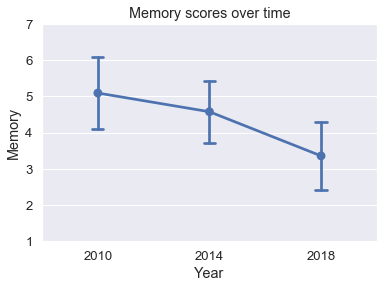

In [10]:
sns.set(context='notebook', font_scale=1.2)
sns.pointplot(data=df, x='Year', y='Memory', capsize=.1, ci='sd')
plt.ylim(1, 7)
_ = plt.title('Memory scores over time')

### Run the ANOVA

To run a repeated-measures ANOVA in pingouin, the following arguments MUST be specified:

- data : the pandas DataFrame (in long-format or wide-format)
- dv : the dependant variable (only if data is in long-format)
- within : the within-subject factor (only if data is in long-format)
- subject : the subject identifier (only if data is in long-format)

In the example below, we are going to test if the means of the memory scores have changed across the three time points:

In [11]:
pg.rm_anova(data=df, dv='Memory', within='Year', subject='Subject')

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Year,2,38,17.365204,0.000004,0.477523,0.987914


From the example above, it is clear that the means of the three time points are significantly different (F(2, 38)=23.9, p=1.89e-07). We can now further test the pairwise differences between each measurements using the [pairwise_ttests](https://pingouin-stats.org/generated/pingouin.pairwise_ttests.html#pingouin.pairwise_ttests) function:

In [12]:
# Holm-corrected pairwise T-tests
pg.pairwise_ttests(data=df, dv='Memory', within='Year', subject='Subject', return_desc=True, padjust='holm')

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Year,2010,2014,5.091534,1.005962,4.575057,0.876200,True,True,1.629473,19.0,two-sided,0.119680,0.119680,holm,0.717,0.536635
1,Year,2010,2018,5.091534,1.005962,3.356848,0.952622,True,True,5.761881,19.0,two-sided,0.000015,0.000045,holm,1532.361,1.735532
2,Year,2014,2018,4.575057,0.876200,3.356848,0.952622,True,True,4.228344,19.0,two-sided,0.000455,0.000910,holm,72.806,1.304627


#### A note on sphericity

The repeated measures ANOVA table is very similar to the one-way ANOVA table, with an additional `eps` column. This refers to the epsilon statistic, which indicates the degree to which sphericity is present or not. An epsilon of 1 means that the condition of sphericity is exactly met. The further epsilon decreases below 1, the greater the violation of sphericity. In the example above, the condition of sphericity is almost exactly met. 

Another way to understand sphericity is to look at the covariance matrix of our data. If the variances of each measurements (i.e. elements on the diagonal of the covariance matrix) are roughly equal AND the covariances between measurements (i.e the off-diagonal elements) are also roughly equal, then we can be pretty confident that the assumption of sphericity is met (this is called *compound symmetry*, which is slightly different and more conservative than sphericity, the latter being that the variances between the pairwise *differences* are equals ; for more details on this, see [here](http://homepages.gold.ac.uk/aphome/spheric.html)).

To compute the covariance matrix, we first need to pivot our data from long-format to repeated measures format, i.e. one column per each repeated measurements.

In [13]:
# Pivot the data
pivot = df.pivot(index='Subject', columns='Year', values='Memory')
pivot.head().round(3)

Year,2010,2014,2018
Subject,,,
0,4.131,5.390,2.356
1,5.798,5.993,1.618
2,5.226,4.051,2.687
3,3.795,5.741,3.459
4,4.537,3.797,3.271


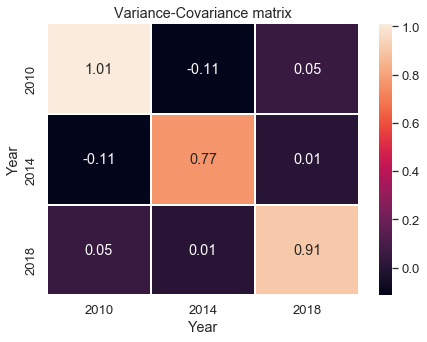

In [14]:
# Plot the variance-covariance matrix
plt.figure(figsize=(7, 5))
ax = sns.heatmap(pivot.cov(), annot=True, fmt='.2f', linewidths=1)
_ = plt.title('Variance-Covariance matrix')

#### What if sphericity is not met?

When you are doing a repeated measures ANOVA, Pingouin automatically tests if the sphericity assumption is met using the [sphericity](https://pingouin-stats.org/generated/pingouin.sphericity.html#pingouin.sphericity) function, which is based on the [Mauchly test](https://en.wikipedia.org/wiki/Mauchly%27s_sphericity_test).

If the sphericity assumption is not met, Pingouin returns the Mauchly test chi-square statistic and p-values, as well as the Greenhouse-Geisser corrected p-value of the ANOVA (The Greenhouse-Geisser correction uses epsilon to correct the degrees of freedom of the ANOVA).

You can force the correction using `correction=True`:

In [15]:
pg.rm_anova(data=df, dv='Memory', within='Year', subject='Subject', correction=True)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Year,2,38,17.365204,0.000004,0.000005,0.477523,0.987914,True,0.987766,0.895132


Another alternative when the sphericity assumption is not met is to use a **one-sample Hotelling T-squared test** (see more [here](http://www.real-statistics.com/multivariate-statistics/multivariate-repeated-measures-tests/one-factor-multivariate-repeated-measures/)) on the differences.

To illustrate this, we'll load a repeated measures ANOVA dataset in wide-format:

In [16]:
data_wide = pg.read_dataset('rm_anova_wide')
data_wide

,Before,1 week,2 week,3 week
0,4.3,5.3,4.8,6.3
1,3.9,2.3,5.6,4.3
2,4.5,2.6,4.1,NaN
3,5.1,4.2,6.0,6.3
4,3.8,3.6,4.8,6.8
5,3.8,5.4,5.1,6.3
6,5.1,3.7,NaN,NaN
7,4.5,3.0,7.7,5.8
8,3.7,7.1,5.5,4.8
9,4.4,4.7,4.2,5.5


Let's now compute the difference between successive columns:

In [17]:
data_wide_diff = data_wide.diff(axis=1).dropna(how='all', axis=1)
data_wide_diff.head()

,1 week,2 week,3 week
0,1.0,-0.5,1.5
1,-1.6,3.3,-1.3
2,-1.9,1.5,NaN
3,-0.9,1.8,0.3
4,-0.2,1.2,2.0


And now let's compute the one-sample Hotelling T-squared test

In [18]:
pg.multivariate_ttest(data_wide_diff)

,T2,F,df1,df2,pval
hotelling,60.142521,15.03563,3,6,0.00338


The results are consistent with a classic one-way repeated measures ANOVA. As one can see below, the p-value of the Hotelling T-squared is roughly located between the uncorrected p-value and the Greenhouse-Geisser p-value. The advantage of the Hotelling T-squared is that it doesn't require the sphericity assumption.

In [19]:
pg.rm_anova(data_wide, correction=True)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Within,3,24,5.200652,0.006557,0.016699,0.393969,0.694329,True,0.306784,0.163365


***

## Mixed ANOVA

In some cases, you might want to take the interation between a within-subject factor (e.g. time) and a between-subject factor (e.g. Group). This is done using a mixed two-way ANOVA.

We are first going to add a group factor to our previously created memory dataset.

In [20]:
df['Sex'] = np.tile(np.repeat(['Men', 'Women'], 10), 3)
df.head()

,Memory,Year,Subject,Sex
0,4.131496,2010,0,Men
1,5.797876,2010,1,Men
2,5.226383,2010,2,Men
3,3.794964,2010,3,Men
4,4.537120,2010,4,Men


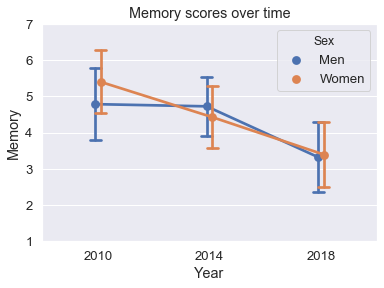

In [21]:
sns.pointplot(data=df, x='Year', y='Memory', hue='Sex', dodge=True, capsize=.1, ci='sd')
plt.ylim(1, 7)
_ = plt.title('Memory scores over time')

In [22]:
pg.mixed_anova(data=df, dv='Memory', between='Sex', within='Year', subject='Subject')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Sex,0.253250,1,18,0.253250,0.283438,0.600967,0.015502,NaN
1,Year,31.732805,2,36,15.866403,17.513541,0.000005,0.493151,0.987914
2,Interaction,2.105975,2,36,1.052987,1.162301,0.324226,0.060656,NaN


In [23]:
# Same but we want a generalized eta-squared ('ng2') instead of the default partial eta-squared ('np2')
pg.mixed_anova(data=df, dv='Memory', between='Sex', within='Year', subject='Subject', effsize='ng2')

,Source,SS,DF1,DF2,MS,F,p-unc,ng2,eps
0,Sex,0.253250,1,18,0.253250,0.283438,0.600967,0.005174,NaN
1,Year,31.732805,2,36,15.866403,17.513541,0.000005,0.394540,0.987914
2,Interaction,2.105975,2,36,1.052987,1.162301,0.324226,0.041454,NaN


In [24]:
pg.pairwise_ttests(data=df, dv='Memory', between='Sex', within='Year', subject='Subject')

,Contrast,Year,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Year,-,2010,2014,True,True,1.629473,19.0,two-sided,0.119680,0.717,0.536635
1,Year,-,2010,2018,True,True,5.761881,19.0,two-sided,0.000015,1532.361,1.735532
2,Year,-,2014,2018,True,True,4.228344,19.0,two-sided,0.000455,72.806,1.304627
3,Sex,-,Men,Women,False,True,-0.532389,18.0,two-sided,0.600967,0.439,-0.228032
4,Year * Sex,2010,Men,Women,False,True,-1.399482,18.0,two-sided,0.178666,0.779,-0.599422
5,Year * Sex,2014,Men,Women,False,True,0.752721,18.0,two-sided,0.461349,0.485,0.322404
6,Year * Sex,2018,Men,Women,False,True,-0.168947,18.0,two-sided,0.867722,0.401,-0.072363


***

## Missing values in repeated measures

### Long-format data

To deal with missing values in long-format dataframe with repeated measures, Pingouin implements the `remove_rm_na` function, which will automatically remove the missing values in specified within-subject factors. To illustrate this, let's load an example dataset

In [25]:
df_missing = pg.read_dataset('rm_missing')
df_missing.head(12)

,Study,Subj,Gender,Session,Time,Memory,BOLD,Mood,File
0,Pilot,1,M,Pre,Evening,4.0,2.0,NaN,S1_pre_evening.csv
1,Pilot,1,M,Pre,Morning,7.0,NaN,NaN,S1_pre_morning.csv
2,Pilot,1,M,Post,Evening,4.0,7.0,NaN,S1_post_evening.csv
3,Pilot,1,M,Post,Morning,5.0,NaN,NaN,S1_post_morning.csv
4,Pilot,2,M,Pre,Evening,5.0,6.0,3.0,S2_pre_evening.csv
5,Pilot,2,M,Pre,Morning,1.0,9.0,9.0,S2_pre_morning.csv
6,Pilot,2,M,Post,Evening,5.0,10.0,8.0,S2_post_evening.csv
7,Pilot,2,M,Post,Morning,6.0,5.0,3.0,S2_post_morning.csv
8,Pilot,3,F,Pre,Evening,NaN,10.0,6.0,S3_pre_evening.csv
9,Pilot,3,F,Pre,Morning,2.0,6.0,5.0,S3_pre_morning.csv


In [26]:
# Let's remove the missing rows in the "Time" factor, based on the values in "Memory"
# The order of within matters: missing values are removed on the last factor
pg.remove_rm_na(data=df_missing, dv='Memory', subject='Subj', within=['Session', 'Time'])

,Study,Subj,Gender,Session,Time,Memory,BOLD,Mood,File
0,Pilot,1,M,Post,Evening,4.0,7.0,NaN,S1_post_evening.csv
1,Pilot,1,M,Post,Morning,5.0,NaN,NaN,S1_post_morning.csv
2,Pilot,1,M,Pre,Evening,4.0,2.0,NaN,S1_pre_evening.csv
3,Pilot,1,M,Pre,Morning,7.0,NaN,NaN,S1_pre_morning.csv
4,Pilot,2,M,Post,Evening,5.0,10.0,8.0,S2_post_evening.csv
5,Pilot,2,M,Post,Morning,6.0,5.0,3.0,S2_post_morning.csv
6,Pilot,2,M,Pre,Evening,5.0,6.0,3.0,S2_pre_evening.csv
7,Pilot,2,M,Pre,Morning,1.0,9.0,9.0,S2_pre_morning.csv
8,Pilot,4,F,Post,Evening,8.0,8.0,5.0,S4_post_evening.csv
9,Pilot,4,F,Post,Morning,2.0,7.0,3.0,S4_post_morning.csv


In [27]:
# If we do not specifiy a specific dv, missing values are taken from all the numeric columns
pg.remove_rm_na(data=df_missing, subject='Subj', within=['Session', 'Time'])

,Study,Subj,Gender,Session,Time,Memory,BOLD,Mood,File
0,Pilot,2,M,Post,Evening,5.0,10.0,8.0,S2_post_evening.csv
1,Pilot,2,M,Post,Morning,6.0,5.0,3.0,S2_post_morning.csv
2,Pilot,2,M,Pre,Evening,5.0,6.0,3.0,S2_pre_evening.csv
3,Pilot,2,M,Pre,Morning,1.0,9.0,9.0,S2_pre_morning.csv
4,Pilot,4,F,Post,Evening,8.0,8.0,5.0,S4_post_evening.csv
5,Pilot,4,F,Post,Morning,2.0,7.0,3.0,S4_post_morning.csv
6,Pilot,4,F,Pre,Evening,8.0,2.0,2.0,S4_pre_evening.csv
7,Pilot,4,F,Pre,Morning,4.0,2.0,0.0,S4_pre_morning.csv
8,Pilot,5,F,Post,Evening,9.0,10.0,8.0,S5_post_evening.csv
9,Pilot,5,F,Post,Morning,3.0,6.0,7.0,S5_post_morning.csv


In [28]:
# Finally, if there are more within-subject factors in the data than specified in `within`, 
# values are first aggregated. The default is to use the mean. In that case, all the non-numeric columns are discarded:
pg.remove_rm_na(data=df_missing, subject='Subj', within='Session', aggregate='mean')

,Subj,Session,Memory,BOLD,Mood
0,2,Post,5.5,7.5,5.5
1,2,Pre,3.0,7.5,6.0
2,3,Post,1.0,4.5,6.0
3,3,Pre,2.0,8.0,5.5
4,4,Post,5.0,7.5,4.0
5,4,Pre,6.0,2.0,1.0
6,6,Post,7.0,3.5,4.0
7,6,Pre,7.5,5.0,8.5
8,7,Post,6.0,8.0,4.0
9,7,Pre,6.5,4.0,6.0


### Wide-format data

To remove missing values in wide-format dataframe, one can simply use the [Pandas dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function:

In [29]:
data_wide

,Before,1 week,2 week,3 week
0,4.3,5.3,4.8,6.3
1,3.9,2.3,5.6,4.3
2,4.5,2.6,4.1,NaN
3,5.1,4.2,6.0,6.3
4,3.8,3.6,4.8,6.8
5,3.8,5.4,5.1,6.3
6,5.1,3.7,NaN,NaN
7,4.5,3.0,7.7,5.8
8,3.7,7.1,5.5,4.8
9,4.4,4.7,4.2,5.5


In [30]:
data_wide.dropna()  # Remove rows with NaN

,Before,1 week,2 week,3 week
0,4.3,5.3,4.8,6.3
1,3.9,2.3,5.6,4.3
3,5.1,4.2,6.0,6.3
4,3.8,3.6,4.8,6.8
5,3.8,5.4,5.1,6.3
7,4.5,3.0,7.7,5.8
8,3.7,7.1,5.5,4.8
9,4.4,4.7,4.2,5.5
11,3.7,3.0,4.0,7.1


In [31]:
data_wide.dropna(axis=1)  # Remove columns with NaN

,1 week
0,5.3
1,2.3
2,2.6
3,4.2
4,3.6
5,5.4
6,3.7
7,3.0
8,7.1
9,4.7
